<a id=top-page></a>
# `pykitPIV` demo: Upload and test the trained RL model

In this Jupyter notebook, we upload the trained reinforcement learning (RL) model.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>

</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
from pykitPIV import FlowField
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

2025-03-18 17:09:06.840302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
save_images = False
filename = None

In [2]:
action_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap_actions = ListedColormap(action_colors)

In [3]:
cmap_displacement = cmc.roma_r

In [4]:
interrogation_window_size = (40,40)
interrogation_window_size_buffer = 0

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [5]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [6]:
flowfield_spec = FlowFieldSpecs(size=(100, 200),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(100, 200),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [7]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [8]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


### Prepare the CNN-based inference model for PIV images:

In [9]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [10]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [11]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [12]:
cues_obj = Cues(sample_every_n=10, 
                normalize_displacement_vectors=False)
cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium` environment:

In [13]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=interrogation_window_size_buffer,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             random_seed=None)

In [14]:
camera_position, cues = env.reset()

In [15]:
cues.shape

(1, 32)

Define the Q-network:

In [16]:
class QNetwork(tf.keras.Model):

    def __init__(self, n_actions, kernel_initializer):

        super(QNetwork, self).__init__()

        self.dense1 = tf.keras.layers.Dense(env.n_cues, activation='linear', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(int(env.n_cues/2), activation='tanh', kernel_initializer=kernel_initializer)
        self.dense3 = tf.keras.layers.Dense(int(env.n_cues/3), activation='tanh', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='linear', kernel_initializer=kernel_initializer)

    def call(self, state):

        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

We are going to use the reward based on divergence:

In [17]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting vortex structures:

In [18]:
def reward_transformation(div):  
    return np.max(np.abs(div))

***

## Test the trained agent on a new environment

In [19]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [20]:
flowfield_spec = FlowFieldSpecs(size=(200, 300),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [21]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [22]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


In [23]:
test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [24]:
camera_position, cues = test_env.reset()

(300,)
(200,)


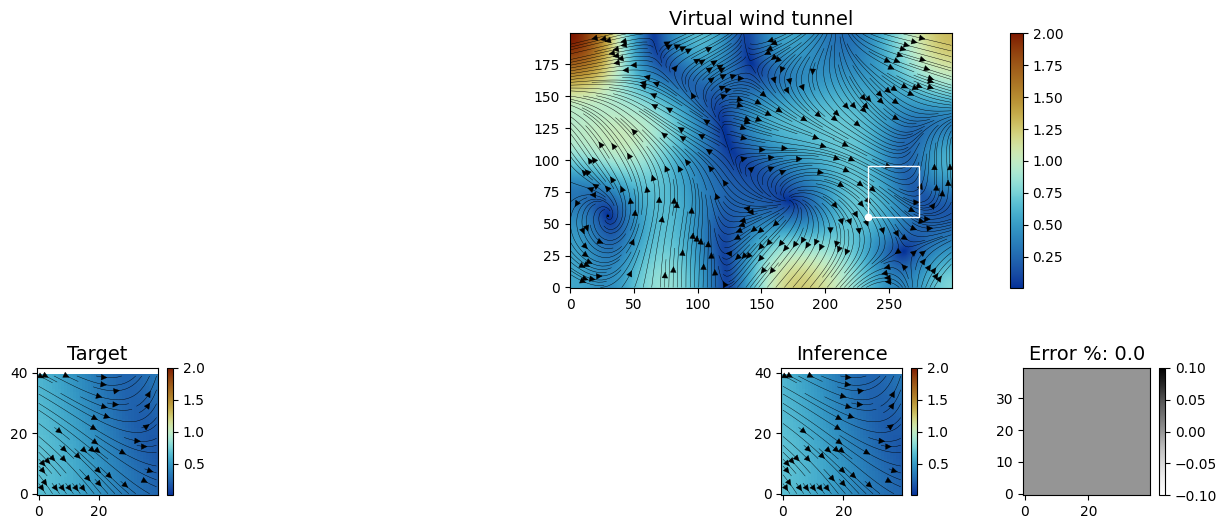

In [25]:
plt = test_env.render(quantity=None,
                      camera_position=camera_position,
                     c='white',
                     s=20,
                     lw=1,
                     normalize_cbars=True,
                     cmap=cmap_displacement,
                     add_streamplot=True,
                     streamplot_density=3,
                     streamplot_color='k',
                     streamplot_linewidth=0.3,
                     figsize=(15,6), 
                     filename=None)

***

## Upload the Q-network trained on the cluster

In [26]:
path = '/Users/kamilazdybal/Desktop/RUN-first-successful-non-normalized-d/large-lr-'

Upload the displacement field:

In [27]:
velocity_u = pd.read_csv(path + 'final-velocity-field-u.csv', sep = ',', header=None).to_numpy()
velocity_v = pd.read_csv(path + 'final-velocity-field-v.csv', sep = ',', header=None).to_numpy()

user_velocity = np.zeros((1,2,200,300))
user_velocity[0,0,:,:] = velocity_u
user_velocity[0,1,:,:] = velocity_v

user_flowfield = FlowField(n_images=1,
                      size=(200, 300),
                      size_buffer=0,
                      random_seed=100)

user_flowfield.upload_velocity_field(user_velocity)

In [28]:
user_flowfield = FlowField(n_images=1,
                           size=(300, 400),
                           size_buffer=0,
                           random_seed=None)

user_flowfield.generate_random_velocity_field(gaussian_filters=(10,10),
                                              n_gaussian_filter_iter=10,
                                              displacement=(2,2))

In [29]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=0,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=None,
             inference_model=None,
             user_flowfield=user_flowfield,
             random_seed=None)

In [30]:
camera_position, cues = env.reset()

In [31]:
cues.shape

(1, 32)

In [32]:
divergence = np.abs(compute_divergence(user_flowfield.velocity_field)[0,:,:])

(40,)
(30,)


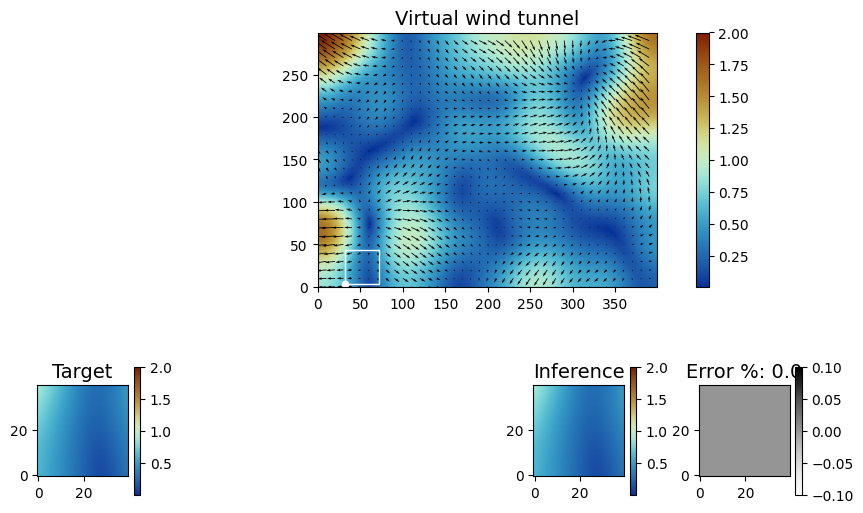

In [34]:
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmap_displacement,
                 add_quiver=True,
                 quiver_step=10,
                 quiver_color='k',
                 add_streamplot=False,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

In [ ]:
plt = env.render(quantity=divergence,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap='coolwarm',
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

In [ ]:
plt = env.render(quantity=learned_policy,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmap_actions,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

In [ ]:
trained_q_network = QNetwork(n_actions=env.n_actions, kernel_initializer = tf.keras.initializers.RandomUniform)
_ = trained_q_network(tf.ones((1, env.n_cues)))

In [ ]:
trained_q_network.load_weights(path + 'QNetwork.keras')

Make inference:

In [ ]:
(_, _, H, W) = env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = env.reset(imposed_camera_position=camera_position)
        q_values = trained_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

In [ ]:
figure = plt.figure(figsize=(20, 4))
spec = figure.add_gridspec(ncols=5, nrows=1, width_ratios=[1,0,1,0,1], height_ratios=[1])

figure_a = figure.add_subplot(spec[0,0])
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(env.action_to_verbose_direction.values()))

figure_b = figure.add_subplot(spec[0,2])
plt.imshow(user_flowfield.velocity_field_magnitude[0,0,:,:], origin='lower', cmap=cmc.roma_r)

figure_c = figure.add_subplot(spec[0,4])

plt.imshow(np.abs(compute_divergence(user_flowfield.velocity_field)[0,:,:]), origin='lower', cmap='coolwarm')
plt.colorbar()

plt.savefig('policy-for-env.png', dpi=300, bbox_inches='tight')

### Visualize one sample trajectory in the test environment

We are going to take a number of steps in the environment:

In [ ]:
n_steps = 100

In [ ]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [ ]:
camera_position, cues = test_env.reset(imposed_camera_position=(60,100))

In [ ]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.online_q_network(cues)

    action = np.argmax(q_values)

    print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=10,
                                                  verbose=False)

In [ ]:
plot_trajectory(test_env.flowfield.velocity_field,
                saved_camera_trajectories,
                interrogation_window_size=interrogation_window_size,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cma,
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=None);

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)